In [1]:
%matplotlib inline
import pandas as ps
import numpy as np
import matplotlib.pyplot as plt
import collections
import sklearn
import seaborn as sns; sns.set()

In [2]:
train_orig = ps.read_csv('Challenge1_Train_aa.csv')

/Users/Sanchita/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train_orig.tail(2)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,flag1,flag2
69998,92616606,6019164,Caucasian,Male,6,NaN,1,1,6,2,...,No,No,No,No,No,No,Ch,Yes,0,0
69999,277875756,6734736,Asian,Male,6,NaN,2,13,4,7,...,No,No,No,No,No,No,No,No,0,0


In [4]:
# Many patients have multiple encounters, the didea was to use the #encounters for each, 
# but then we can only use 1 entry per person

#counter = collections.Counter(train_orig.patient_nbr)
#len(train_orig.patient_nbr)
#len(counter.values())
#train_orig['NumPtVisit'] = counter.values()

In [5]:
#train_orig.dtypes

In [4]:
# Remove features and labels to create training data  

#for i in train_orig.columns.values: print i
#print len(train_orig.columns)
remv_col = [0,5,10,11,18,19,21,22,24,26]
train_temp = train_orig.drop(train_orig.columns[remv_col], axis=1)

In [7]:
train_temp.dtypes

patient_nbr                  int64
race                        object
gender                      object
age                          int64
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
long_label_1                object
long_label_2                object
short_label_3               object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide         

In [5]:
# Separate numeric and non-numeric data for converting to numeric
train_num = train_temp.select_dtypes(include=['int64']).copy()
train_obj = train_temp.select_dtypes(include=['object']).copy()

In [6]:
train_num.tail(2)
train_obj.tail(2)

,race,gender,long_label_1,long_label_2,short_label_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,...,examide,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed
69998,Caucasian,Male,'(996-999) COMPLICATIONS OF SURGICAL AND MEDIC...,NaN,NaN,None,None,No,Up,No,...,No,No,No,No,No,No,No,No,Ch,Yes
69999,Asian,Male,NaN,NaN,NaN,None,None,No,No,No,...,No,No,No,No,No,No,No,No,No,No


In [7]:
# Encode missing data from '?' as missing for categorical variables
train_obj = train_obj.replace('?', 'Missing')
train_obj = train_obj.where(ps.notnull(train_obj),"Missing")

In [8]:
# One-hot encoding for variables that have very few categories
train_obj = ps.get_dummies(train_obj, columns=['race', 'gender', 'change', 'diabetesMed'])

In [9]:
for i in train_obj.columns.values[:-12]: 
    train_obj[i] = train_obj[i].astype('category')
    train_obj[i] = train_obj[i].cat.codes 

In [10]:
train_obj.tail()
#train_obj.dtypes
#print len(train_obj)

,long_label_1,long_label_2,short_label_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,...,race_Caucasian,race_Hispanic,race_Missing,race_Other,gender_Female,gender_Male,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
69995,102,104,18,2,2,1,1,1,1,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
69996,102,104,18,2,2,2,1,1,1,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
69997,102,104,18,2,0,1,1,1,1,1,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
69998,102,104,18,2,2,1,3,1,1,1,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
69999,104,104,18,2,2,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [11]:
train_num['flag1'] = train_num['flag1'].astype('category')
train_num['flag1'] = train_num['flag1'].cat.codes
train_num['flag2'] = train_num['flag2'].astype('category')
train_num['flag2'] = train_num['flag2'].cat.codes

In [12]:
#train_obj['patient_nbr'] = train_num['patient_nbr']
train_data = ps.concat([train_num, train_obj],axis=1)


In [13]:
tt = train_data.columns.tolist()
tt.insert(len(tt),tt.pop(tt.index('flag2')))
tt.insert(len(tt),tt.pop(tt.index('flag1')))


In [14]:
int_df = train_data[tt]
#int_df = int_df.drop(['medical_specialty'], axis=1)
all_features = int_df.columns.values[2:-2]
from sklearn.cross_validation import train_test_split
train, test = train_test_split(int_df, test_size=0.2)

/Users/Sanchita/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
array = train.values
X = array[:,2:-2]
Y = array[:,-2]
Y

array([ 1.,  0.,  0., ...,  1.,  0.,  1.])

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
#model = LogisticRegression()
#rfe = RFE(model, 3)
#fit = rfe.fit(X, Y)
clf = ExtraTreesClassifier()
clf = clf.fit(X,Y)
clf.feature_importances_
model= SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

In [17]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, random_state=42)

In [18]:
X_new.shape, X_new.dtype.names

((56000, 16), None)

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [22]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [45]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(Xtrain, ytrain)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] max_features=log2, n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_depth=30, bootstrap=True 
[CV] max_features=log2, n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_depth=30, bootstrap=True 
[CV] max_features=log2, n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_depth=30, bootstrap=True 
[CV] max_features=log2, n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_depth=10, bootstrap=True 
[CV] max_features=log2, n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_depth=10, bootstrap=True 
[CV] max_features=log2, n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_depth=10, bootstrap=True 
[CV] max_features=log2, n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_depth=10, bootstrap=False 
[CV] max_features=log2, n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_depth=10, bootstrap=False 
[CV]  max_features=log2, n

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.9min


[CV]  max_features=auto, n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_depth=70, bootstrap=True, total=  24.0s
[CV] max_features=log2, n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_depth=90, bootstrap=False 
[CV]  max_features=auto, n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_depth=70, bootstrap=True, total=  24.2s
[CV] max_features=log2, n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_depth=90, bootstrap=False 
[CV]  max_features=auto, n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_depth=10, bootstrap=False, total= 1.6min
[CV] max_features=log2, n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_depth=90, bootstrap=False 
[CV]  max_features=auto, n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_depth=10, bootstrap=False, total= 1.6min
[CV] max_features=log2, n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_depth=10, bootstrap=False 
[CV]  max_features=auto,

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 28.3min


[CV] max_features=auto, n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_depth=50, bootstrap=False 
[CV]  max_features=auto, n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_depth=90, bootstrap=True, total= 2.5min
[CV]  max_features=auto, n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_depth=90, bootstrap=True, total= 2.5min
[CV] max_features=auto, n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_depth=50, bootstrap=False 
[CV] max_features=auto, n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_depth=50, bootstrap=False 
[CV]  max_features=log2, n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_depth=70, bootstrap=False, total= 1.4min
[CV] max_features=auto, n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_depth=50, bootstrap=False 
[CV]  max_features=log2, n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_depth=110, bootstrap=False, total=  50.0s
[CV] max_features=

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 57.7min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'max_features': ['auto', 'log2'], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [46]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1800}

In [54]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

from sklearn.metrics import accuracy_score
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(Xtrain, ytrain)
base_accuracy = evaluate(base_model, Xtest, ytest)
yfit = base_model.predict(Xtest)
accu = accuracy_score(ytest, yfit)
print("Mean accuracy score: %d", accu)

Model Performance
Average Error: 0.4041 degrees.
Accuracy = nan%.
Mean accuracy score: %d 0.595928571429


In [56]:
best_random = rf_random.best_estimator_
best_random.fit(Xtrain, ytrain)
yfit = best_random.predict(Xtest)
accu = accuracy_score(ytest, yfit)
print("Mean accuracy score: %d", accu)

Mean accuracy score: %d 0.638571428571


In [70]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': ['log2'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [1200, 1600, 2000, 2200]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(Xtrain, ytrain)
grid_search.best_params_

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] max_features=log2, n_estimators=1200, min_samples_split=2, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV] max_features=log2, n_estimators=1200, min_samples_split=2, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV] max_features=log2, n_estimators=1200, min_samples_split=2, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV] max_features=log2, n_estimators=1600, min_samples_split=2, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV] max_features=log2, n_estimators=1600, min_samples_split=2, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV] max_features=log2, n_estimators=1600, min_samples_split=2, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV] max_features=log2, n_estimators=2000, min_samples_split=2, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV] max_features=log2, n_estimators=2000, min_samples_split=2, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV]  max_features=log2, 

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.1min


[CV]  max_features=log2, n_estimators=2200, min_samples_split=3, max_depth=80, min_samples_leaf=3, bootstrap=True, total= 1.9min
[CV] max_features=log2, n_estimators=2200, min_samples_split=4, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV]  max_features=log2, n_estimators=1200, min_samples_split=4, max_depth=80, min_samples_leaf=3, bootstrap=True, total= 1.0min
[CV] max_features=log2, n_estimators=2200, min_samples_split=4, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV]  max_features=log2, n_estimators=1600, min_samples_split=4, max_depth=80, min_samples_leaf=3, bootstrap=True, total= 1.4min
[CV] max_features=log2, n_estimators=2200, min_samples_split=4, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV]  max_features=log2, n_estimators=1600, min_samples_split=4, max_depth=80, min_samples_leaf=3, bootstrap=True, total= 1.4min
[CV] max_features=log2, n_estimators=1200, min_samples_split=2, max_depth=80, min_samples_leaf=4, bootstrap=True 
[CV]  max_features=log2, n_e

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 32.1min


[CV]  max_features=log2, n_estimators=2200, min_samples_split=4, max_depth=90, min_samples_leaf=3, bootstrap=True, total= 1.9min
[CV] max_features=log2, n_estimators=2200, min_samples_split=2, max_depth=90, min_samples_leaf=4, bootstrap=True 
[CV]  max_features=log2, n_estimators=1600, min_samples_split=2, max_depth=90, min_samples_leaf=4, bootstrap=True, total= 1.3min
[CV] max_features=log2, n_estimators=2200, min_samples_split=2, max_depth=90, min_samples_leaf=4, bootstrap=True 
[CV]  max_features=log2, n_estimators=1600, min_samples_split=2, max_depth=90, min_samples_leaf=4, bootstrap=True, total= 1.3min
[CV] max_features=log2, n_estimators=1200, min_samples_split=3, max_depth=90, min_samples_leaf=4, bootstrap=True 
[CV]  max_features=log2, n_estimators=1600, min_samples_split=2, max_depth=90, min_samples_leaf=4, bootstrap=True, total= 1.3min
[CV] max_features=log2, n_estimators=1200, min_samples_split=3, max_depth=90, min_samples_leaf=4, bootstrap=True 
[CV]  max_features=log2, n_e

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 76.3min


[CV]  max_features=log2, n_estimators=1200, min_samples_split=4, max_depth=110, min_samples_leaf=3, bootstrap=True, total= 1.1min
[CV] max_features=log2, n_estimators=2200, min_samples_split=4, max_depth=110, min_samples_leaf=3, bootstrap=True 
[CV]  max_features=log2, n_estimators=2200, min_samples_split=3, max_depth=110, min_samples_leaf=3, bootstrap=True, total= 1.9min
[CV] max_features=log2, n_estimators=2200, min_samples_split=4, max_depth=110, min_samples_leaf=3, bootstrap=True 
[CV]  max_features=log2, n_estimators=1600, min_samples_split=4, max_depth=110, min_samples_leaf=3, bootstrap=True, total= 1.4min
[CV] max_features=log2, n_estimators=2200, min_samples_split=4, max_depth=110, min_samples_leaf=3, bootstrap=True 
[CV]  max_features=log2, n_estimators=1600, min_samples_split=4, max_depth=110, min_samples_leaf=3, bootstrap=True, total= 1.4min
[CV] max_features=log2, n_estimators=1200, min_samples_split=2, max_depth=110, min_samples_leaf=4, bootstrap=True 
[CV]  max_features=l

[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 94.5min finished


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 1600}

In [78]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=110, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=1600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [82]:
#best_grid = grid_search.best_estimator_
best_grid = RandomForestClassifier(bootstrap=True, class_weight="balanced", criterion='gini',
            max_depth=110, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=1600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
best_grid.fit(Xtrain, ytrain)
yfit = best_grid.predict(Xtest)
accu = accuracy_score(ytest, yfit)
print("Mean accuracy score: %d", accu)

Mean accuracy score: %d 0.644928571429


In [91]:
best_grid.classes_

array([ 0.,  1.])

In [92]:
yprob = best_grid.predict_proba(Xtest)
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(ytest,yprob[:,1])
metrics.auc(fpr,tpr)

0.69241473339211457

In [93]:
yprob[1:5,:]

array([[ 0.22954038,  0.77045962],
       [ 0.58904773,  0.41095227],
       [ 0.5329878 ,  0.4670122 ],
       [ 0.56976067,  0.43023933]])

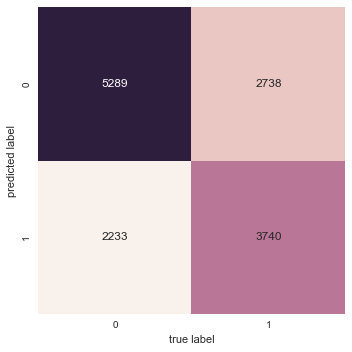

In [94]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [87]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=0, 
                             verbose=1, class_weight="balanced", oob_score=True)
clf.fit(Xtrain,ytrain)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   12.8s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:   29.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   32.3s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=30, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=True, random_state=0, verbose=1, warm_start=False)

In [83]:
from sklearn.metrics import accuracy_score

yfit = clf.predict(Xtest)
accu = accuracy_score(ytest, yfit)
print("Out-of-bag score estimate: %f", clf.oob_score_) 
print("Mean accuracy score: %d", accu) 

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    1.7s


Out-of-bag score estimate: %f 0.626166666667
Mean accuracy score: %d 0.628428571429


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished


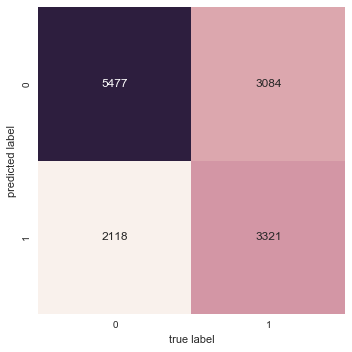

In [84]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [29]:
#print("Num Features: %d") % fit.n_features_
#print("Selected Features: %s") % all_features[fit.support_
#print("Feature Ranking: %s") % fit.ranking_

In [53]:
from sklearn.svm import SVC
from sklearn.decomposition import RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=5, copy=True)
pca.fit(X)
print(pca.explained_variance_ratio_)

/Users/sanchi4u/anaconda/envs/Py_MachineLearning/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


[ 0.35313091  0.29387252  0.25379574  0.04144676  0.01811596]


In [57]:
clf = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, clf)

In [36]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, Y, random_state=42)

In [28]:
from sklearn.grid_search import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

/Users/sanchi4u/anaconda/envs/Py_MachineLearning/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/sanchi4u/anaconda/envs/Py_MachineLearning/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sanchi4u/anaconda/envs/Py_MachineLearning/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomi

CPU times: user 1h 41s, sys: 47 s, total: 1h 1min 28s
Wall time: 1h 2min 17s
{'svc__gamma': 0.001, 'svc__C': 1}


In [ ]:
grid.fit(Xtrain, ytrain)
print grid.best_estimator_
model = grid.best_estimator_

/Users/sanchi4u/anaconda/envs/Py_MachineLearning/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sanchi4u/anaconda/envs/Py_MachineLearning/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sanchi4u/anaconda/envs/Py_MachineLearning/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; Randomi

In [67]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

In [83]:
yfit[1:50], ytest[1:50]
np.count_nonzero(ytrain)

19187

In [69]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit))

             precision    recall  f1-score   support

          0       0.60      0.49      0.54      7455
          1       0.52      0.63      0.57      6545

avg / total       0.56      0.55      0.55     14000



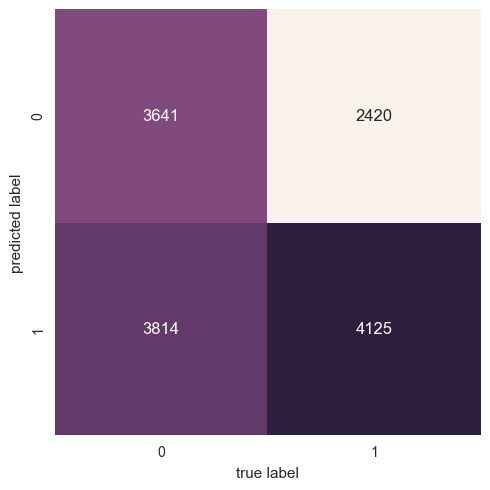

In [78]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [75]:
#clf.fit(X_pca, Y)

#pred = clf.predict(test.values[:,2:-2])
#print 'accuracy score: %0.3f' % sklearn.metrics.accuracy_score(test.values[:,-2], pred)

In [ ]:
#from sklearn.svm import SVC  # "Support Vector Classifier"
#clf = SVC(kernel='linear')
#clf.fit(X, Y)

#pred = clf.predict(test.values[:,2:-2])
#print 'accuracy score: %0.3f' % sklearn.metrics.accuracy_score(test.values[:,-2], pred)